In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import imageio
import numpy as np
import PIL
import time
from IPython import display

from tensorflow.keras import layers

In [2]:
# loading and pre-processing the data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

print("Before: " + str(train_images.shape) +" is of type "+ str(train_images.dtype))

# normalize the images to [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print("After: " + str(train_images.shape) +" is of type "+ str(train_images.dtype))

# TO ASK

train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Before: (60000, 28, 28) is of type uint8
After: (60000, 28, 28, 1) is of type float32


In [3]:
def make_generator_model():
    generator = tf.keras.models.Sequential()
    
    generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # why this?
    # TO ASK: use_bias=False
    
    generator.add(layers.BatchNormalization())
    # TO READ: mathematics
    
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Reshape((7, 7, 256)))
    # TO ASK
    assert generator.output_shape == (None, 7, 7, 256)
    
    generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert generator.output_shape == (None, 7, 7, 128)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert generator.output_shape == (None, 14, 14, 64)
    # TO READ: strides in deconvolution
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert generator.output_shape == (None, 28, 28, 1)
    # NOTE: always add 'tanh' as activation fn in final layer of generator model
    
    return generator

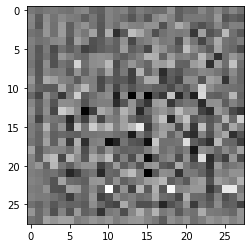

In [4]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    # TO ASK: batch_shape
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # TO ASK: dropout vs trainable=False
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [7]:
# testing the discriminator model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00095931]], shape=(1, 1), dtype=float32)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
# calculating loss for discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
# calculating loss for generator

# ideally prediction should be near to 0 but we test it for a value near to 1
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
# saving checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [13]:
# define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
@tf.function # TO ASK
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # TO READ
        generated_images = generator(noise, training=True) # WOT ??
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # TO ASK?? BACKPROP?? 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [16]:
def generate_and_save_images(model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

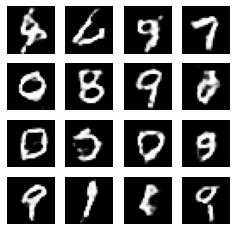

In [19]:
train(train_dataset, EPOCHS)

In [ ]:
# use when needed
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [21]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


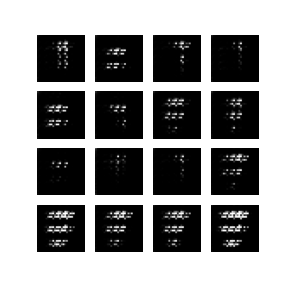

In [24]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
